# Diffusion model from scratch: Image generation

### 1.052/1.121/2.174J: Advancing Mechanics and Materials via Machine Learning

#### Markus J. Buehler, MIT


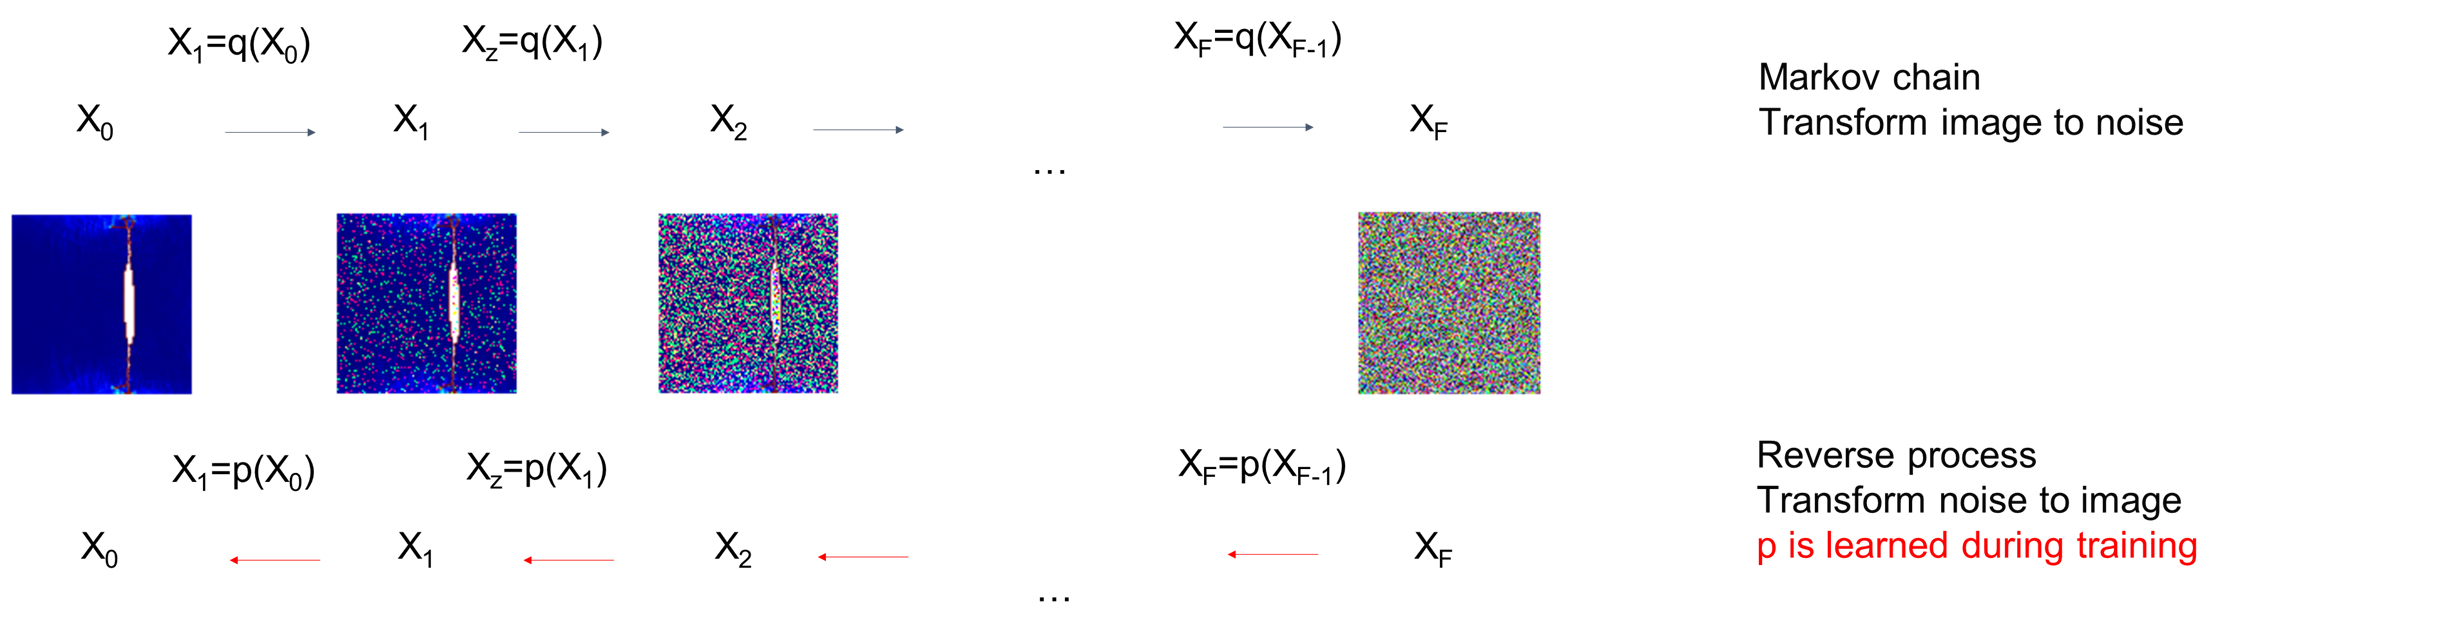

In [1]:
import torch
 
import torchvision
 
import matplotlib.pyplot as plt
import numpy as np
 
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR

from torch.utils.data import DataLoader,Dataset
from torchvision.io import read_image
import pandas as pd
from sklearn.model_selection import train_test_split

import os,sys
import math
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import matplotlib.pyplot as plt

import numpy as np
import cv2
import PIL 
from PIL import Image, ImageOps

import pickle

from PIL import Image
import time
to_pil = transforms.ToPILImage()
print("Torch version:", torch.__version__) 

Torch version: 2.3.0+cu121


In [2]:
CPUonly=False
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

if CPUonly == True:
     print ("CPU!")
     device = torch.device("cpu")

In [3]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU (UUID: GPU-9e918a2c-b990-02f9-111b-68f2425901bf)


In [5]:
print (device)

cuda


#### Parameters

In [6]:
batch_size_=32

im_res=128

prefix = './output_diffusion/'
 
if not os.path.exists(prefix):
        os.mkdir (prefix)

#### Construct the Diffusion model

In [10]:
import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torch.optim import Adam
from torchvision import transforms as T, utils

from einops import rearrange, reduce
from einops.layers.torch import Rearrange

from PIL import Image
#from tqdm.auto import tqdm
from tqdm.notebook import tqdm

from ema_pytorch import EMA

from accelerate import Accelerator

# constants
ModelPrediction =  namedtuple('ModelPrediction', ['pred_noise', 'pred_x_start'])

to_pil = transforms.ToPILImage()

def count_parameters (imagen):

    pytorch_total_params = sum(p.numel() for p in imagen.parameters())
    pytorch_total_params_trainable = sum(p.numel() for p in imagen.parameters() if p.requires_grad)

    print ("----------------------------------------------------------------------------------------------------")
    print ("Total parameters: ", pytorch_total_params," trainable parameters: ", pytorch_total_params_trainable)
    print ("----------------------------------------------------------------------------------------------------")

    return

# helper functions
# https://github.com/lucidrains/denoising-diffusion-pytorch

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def identity(t, *args, **kwargs):
    return t

def cycle(dl):
    while True:
        for data in dl:
            yield data

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def convert_image_to(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image

def l2norm(t):
    return F.normalize(t, dim = -1)

# normalization functions

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

# small helper modules

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Conv2d(dim, default(dim_out, dim), 4, 2, 1)

class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """
    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, 'o ... -> o 1 1 1', 'mean')
        var = reduce(weight, 'o ... -> o 1 1 1', partial(torch.var, unbiased = False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(x, normalized_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) * (var + eps).rsqrt() * self.g

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# sinusoidal positional embeds

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class LearnedSinusoidalPosEmb(nn.Module):
    """ following @crowsonkb 's lead with learned sinusoidal pos emb """
    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim))

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered

# building block modules

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, groups = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):

        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        return self.to_out(out)

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32, scale = 10):
        super().__init__()
        self.scale = scale
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q, k = map(l2norm, (q, k))

        sim = einsum('b h d i, b h d j -> b h i j', q, k) * self.scale
        attn = sim.softmax(dim = -1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)

# model

class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 3,
        self_condition = False,
        resnet_block_groups = 8,
        learned_variance = False,
        learned_sinusoidal_cond = False,
        learned_sinusoidal_dim = 16
    ):
        super().__init__()

        # determine dimensions

        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings

        time_dim = dim * 4

        self.learned_sinusoidal_cond = learned_sinusoidal_cond

        if learned_sinusoidal_cond:
            sinu_pos_emb = LearnedSinusoidalPosEmb(learned_sinusoidal_dim)
            fourier_dim = learned_sinusoidal_dim + 1
        else:
            sinu_pos_emb = SinusoidalPosEmb(dim)
            fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond = None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim = 1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

# gaussian diffusion trainer class

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype = torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        model,
        *,
        image_size,
        timesteps = 1000,
        sampling_timesteps = None,
        loss_type = 'l1',
        objective = 'pred_noise',
        beta_schedule = 'cosine',
        p2_loss_weight_gamma = 0., # p2 loss weight, from https://arxiv.org/abs/2204.00227 - 0 is equivalent to weight of 1 across time - 1. is recommended
        p2_loss_weight_k = 1,
        ddim_sampling_eta = 1.
    ):
        super().__init__()
        assert not (type(self) == GaussianDiffusion and model.channels != model.out_dim)
        assert not model.learned_sinusoidal_cond

        self.model = model
        self.channels = self.model.channels
        self.self_condition = self.model.self_condition

        self.image_size = image_size

        self.objective = objective

        assert objective in {'pred_noise', 'pred_x0'}, 'objective must be either pred_noise (predict noise) or pred_x0 (predict image start)'

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.loss_type = loss_type

        # sampling related parameters

        self.sampling_timesteps = default(sampling_timesteps, timesteps) # default num sampling timesteps to number of timesteps at training

        assert self.sampling_timesteps <= timesteps
        self.is_ddim_sampling = self.sampling_timesteps < timesteps
        self.ddim_sampling_eta = ddim_sampling_eta

        # helper function to register buffer from float64 to float32

        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))

        register_buffer('betas', betas)
        register_buffer('alphas_cumprod', alphas_cumprod)
        register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        # calculations for diffusion q(x_t | x_{t-1}) and others

        register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        register_buffer('log_one_minus_alphas_cumprod', torch.log(1. - alphas_cumprod))
        register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_cumprod))
        register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_cumprod - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)

        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)

        register_buffer('posterior_variance', posterior_variance)

        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain

        register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min =1e-20)))
        register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
        register_buffer('posterior_mean_coef2', (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod))

        # calculate p2 reweighting

        register_buffer('p2_loss_weight', (p2_loss_weight_k + alphas_cumprod / (1 - alphas_cumprod)) ** -p2_loss_weight_gamma)

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def predict_noise_from_start(self, x_t, t, x0):
        return (
            (extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - x0) / \
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def model_predictions(self, x, t, x_self_cond = None, clip_x_start = False):
        model_output = self.model(x, t, x_self_cond)
        maybe_clip = partial(torch.clamp, min = -1., max = 1.) if clip_x_start else identity

        if self.objective == 'pred_noise':
            pred_noise = model_output
            x_start = self.predict_start_from_noise(x, t, pred_noise)
            x_start = maybe_clip(x_start)

        elif self.objective == 'pred_x0':
            x_start = model_output
            x_start = maybe_clip(x_start)
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        return ModelPrediction(pred_noise, x_start)

    def p_mean_variance(self, x, t, x_self_cond = None, clip_denoised = True):
        preds = self.model_predictions(x, t, x_self_cond)
        x_start = preds.pred_x_start

        if clip_denoised:
            x_start.clamp_(-1., 1.)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start = x_start, x_t = x, t = t)
        return model_mean, posterior_variance, posterior_log_variance, x_start

    @torch.no_grad()
    def p_sample(self, x, t: int, x_self_cond = None, clip_denoised = True):
        b, *_, device = *x.shape, x.device
        batched_times = torch.full((x.shape[0],), t, device = x.device, dtype = torch.long)
        model_mean, _, model_log_variance, x_start = self.p_mean_variance(x = x, t = batched_times, x_self_cond = x_self_cond, clip_denoised = clip_denoised)
        noise = torch.randn_like(x) if t > 0 else 0. # no noise if t == 0
        pred_img = model_mean + (0.5 * model_log_variance).exp() * noise
        return pred_img, x_start

    @torch.no_grad()
    def p_sample_loop(self, shape):
        batch, device = shape[0], self.betas.device

        img = torch.randn(shape, device=device)

        x_start = None

        for t in tqdm(reversed(range(0, self.num_timesteps)), desc = 'sampling loop time step', total = self.num_timesteps):
            self_cond = x_start if self.self_condition else None
            img, x_start = self.p_sample(img, t, self_cond)

        img = unnormalize_to_zero_to_one(img)
        return img

    @torch.no_grad()
    def ddim_sample(self, shape, clip_denoised = True):
        batch, device, total_timesteps, sampling_timesteps, eta, objective = shape[0], self.betas.device, self.num_timesteps, self.sampling_timesteps, self.ddim_sampling_eta, self.objective

        times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
        times = list(reversed(times.int().tolist()))
        time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

        img = torch.randn(shape, device = device)

        x_start = None

        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
            time_cond = torch.full((batch,), time, device=device, dtype=torch.long)
            self_cond = x_start if self.self_condition else None
            pred_noise, x_start, *_ = self.model_predictions(img, time_cond, self_cond, clip_x_start = clip_denoised)

            if time_next < 0:
                img = x_start
                continue

            alpha = self.alphas_cumprod[time]
            alpha_next = self.alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(img)

            img = x_start * alpha_next.sqrt() + \
                  c * pred_noise + \
                  sigma * noise

        img = unnormalize_to_zero_to_one(img)
        return img

    @torch.no_grad()
    def sample(self, batch_size = 16):
        image_size, channels = self.image_size, self.channels
        sample_fn = self.p_sample_loop if not self.is_ddim_sampling else self.ddim_sample
        return sample_fn((batch_size, channels, image_size, image_size))

    @torch.no_grad()
    def interpolate(self, x1, x2, t = None, lam = 0.5):
        b, *_, device = *x1.shape, x1.device
        t = default(t, self.num_timesteps - 1)

        assert x1.shape == x2.shape

        t_batched = torch.stack([torch.tensor(t, device = device)] * b)
        xt1, xt2 = map(lambda x: self.q_sample(x, t = t_batched), (x1, x2))

        img = (1 - lam) * xt1 + lam * xt2
        for i in tqdm(reversed(range(0, t)), desc = 'interpolation sample time step', total = t):
            img = self.p_sample(img, torch.full((b,), i, device=device, dtype=torch.long))

        return img

    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    @property
    def loss_fn(self):
        if self.loss_type == 'l1':
            return F.l1_loss
        elif self.loss_type == 'l2':
            return F.mse_loss
        else:
            raise ValueError(f'invalid loss type {self.loss_type}')

    def p_losses(self, x_start, t, noise = None):
        b, c, h, w = x_start.shape
        noise = default(noise, lambda: torch.randn_like(x_start))

        # noise sample

        x = self.q_sample(x_start = x_start, t = t, noise = noise)

        # if doing self-conditioning, 50% of the time, predict x_start from current set of times
        # and condition with unet with that
        # this technique will slow down training by 25%, but seems to lower FID significantly

        x_self_cond = None
        if self.self_condition and random() < 0.5:
            with torch.no_grad():
                x_self_cond = self.model_predictions(x, t).pred_x_start
                x_self_cond.detach_()

        # predict and take gradient step

        model_out = self.model(x, t, x_self_cond)

        if self.objective == 'pred_noise':
            target = noise
        elif self.objective == 'pred_x0':
            target = x_start
        else:
            raise ValueError(f'unknown objective {self.objective}')

        loss = self.loss_fn(model_out, target, reduction = 'none')
        loss = reduce(loss, 'b ... -> b (...)', 'mean')

        loss = loss * extract(self.p2_loss_weight, t, loss.shape)
        return loss.mean()

    def forward(self, img, *args, **kwargs):
        b, c, h, w, device, img_size, = *img.shape, img.device, self.image_size
        assert h == img_size and w == img_size, f'height and width of image must be {img_size}'
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()

        img = normalize_to_neg_one_to_one(img)
        return self.p_losses(img, t, *args, **kwargs)

# dataset classes

class Dataset(Dataset):
    def __init__(
        self,
        folder,
        image_size,
        exts = ['jpg', 'jpeg', 'png', 'tiff'],
        augment_horizontal_flip = False,
        convert_image_to = None
    ):
        super().__init__()
        self.folder = folder
        self.image_size = image_size
        self.paths = [p for ext in exts for p in Path(f'{folder}').glob(f'**/*.{ext}')]

        maybe_convert_fn = partial(convert_image_to, convert_image_to) if exists(convert_image_to) else nn.Identity()

        self.transform = T.Compose([
            T.Lambda(maybe_convert_fn),
            T.Resize(image_size),
            T.RandomHorizontalFlip() if augment_horizontal_flip else nn.Identity(),
            T.CenterCrop(image_size),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(path)
        return self.transform(img)

# trainer class

class Trainer(object):
    def __init__(
        self,
        diffusion_model,
        folder,
        *,
        train_batch_size = 16,
        gradient_accumulate_every = 1,
        augment_horizontal_flip = True,
        train_lr = 1e-4,
        train_num_steps = 100000,
        ema_update_every = 10,
        ema_decay = 0.995,
        adam_betas = (0.9, 0.99),
        save_and_sample_every = 1000,
        num_samples = 25,
        results_folder = './results',
        amp = False,
        fp16 = False,
        split_batches = True,
        convert_image_to = None
    ):
        super().__init__()

        self.accelerator = Accelerator(
            split_batches = split_batches,
            mixed_precision = 'fp16' if fp16 else 'no'
        )

        self.accelerator.native_amp = amp

        self.model = diffusion_model

        assert has_int_squareroot(num_samples), 'number of samples must have an integer square root'
        self.num_samples = num_samples
        self.save_and_sample_every = save_and_sample_every

        self.batch_size = train_batch_size
        self.gradient_accumulate_every = gradient_accumulate_every

        self.train_num_steps = train_num_steps
        self.image_size = diffusion_model.image_size

        # dataset and dataloader

        self.ds = Dataset(folder, self.image_size, augment_horizontal_flip = augment_horizontal_flip, convert_image_to = convert_image_to)
        dl = DataLoader(self.ds, batch_size = train_batch_size, shuffle = True, pin_memory = True, num_workers = cpu_count())

        dl = self.accelerator.prepare(dl)
        self.dl = cycle(dl)

        # optimizer

        self.opt = Adam(diffusion_model.parameters(), lr = train_lr, betas = adam_betas)

        # for logging results in a folder periodically

        if self.accelerator.is_main_process:
            self.ema = EMA(diffusion_model, beta = ema_decay, update_every = ema_update_every)

            self.results_folder = Path(results_folder)
            self.results_folder.mkdir(exist_ok = True)

        # step counter state

        self.step = 0

        # prepare model, dataloader, optimizer with accelerator

        self.model, self.opt = self.accelerator.prepare(self.model, self.opt)

    def save(self, milestone):
        if not self.accelerator.is_local_main_process:
            return

        data = {
            'step': self.step,
            'model': self.accelerator.get_state_dict(self.model),
            'opt': self.opt.state_dict(),
            'ema': self.ema.state_dict(),
            'scaler': self.accelerator.scaler.state_dict() if exists(self.accelerator.scaler) else None
        }

        torch.save(data, str(self.results_folder / f'model-{milestone}.pt'))

    def load(self, milestone):
        accelerator = self.accelerator
        device = accelerator.device

        data = torch.load(str(self.results_folder / f'model-{milestone}.pt'), map_location=device)

        model = self.accelerator.unwrap_model(self.model)
        model.load_state_dict(data['model'])

        self.step = data['step']
        self.opt.load_state_dict(data['opt'])
        self.ema.load_state_dict(data['ema'])

        if exists(self.accelerator.scaler) and exists(data['scaler']):
            self.accelerator.scaler.load_state_dict(data['scaler'])

    def train(self):
        accelerator = self.accelerator
        device = accelerator.device

        with tqdm(initial = self.step, total = self.train_num_steps, disable = not accelerator.is_main_process) as pbar:

            while self.step < self.train_num_steps:

                total_loss = 0.

                for _ in range(self.gradient_accumulate_every):
                    data = next(self.dl).to(device)

                    with self.accelerator.autocast():
                        loss = self.model(data)
                        loss = loss / self.gradient_accumulate_every
                        total_loss += loss.item()

                    self.accelerator.backward(loss)

                pbar.set_description(f'loss: {total_loss:.4f}')

                accelerator.wait_for_everyone()

                self.opt.step()
                self.opt.zero_grad()

                accelerator.wait_for_everyone()

                self.step += 1
                if accelerator.is_main_process:
                    self.ema.to(device)
                    self.ema.update()

                    if self.step != 0 and self.step % self.save_and_sample_every == 0:
                        self.ema.ema_model.eval()

                        with torch.no_grad():
                            milestone = self.step // self.save_and_sample_every
                            batches = num_to_groups(self.num_samples, self.batch_size)
                            all_images_list = list(map(lambda n: self.ema.ema_model.sample(batch_size=n), batches))

                        all_images = torch.cat(all_images_list, dim = 0)
                        utils.save_image(all_images, str(self.results_folder / f'sample-{milestone}.png'), nrow = int(math.sqrt(self.num_samples)))
                        self.save(milestone)

                pbar.update(1)

        accelerator.print('training complete')

#### Testing the model...

In [16]:
import torch

model = Unet(
    dim = 128,
    dim_mults = (1, 2, 4, 8),
    channels = 3,
    self_condition = False,
    resnet_block_groups = 8,
    learned_variance = False,
    learned_sinusoidal_cond = False,
    learned_sinusoidal_dim = 16
).to(device)

diffusion = GaussianDiffusion(
    model,
    image_size = im_res,
    timesteps = 1000,   # number of steps
    loss_type = 'l1'    # L1 or L2
).to(device)


In [12]:
count_parameters (diffusion)

----------------------------------------------------------------------------------------------------
Total parameters:  142872835  trainable parameters:  142872835
----------------------------------------------------------------------------------------------------


In [13]:
training_images = torch.randn(8, 3, im_res, im_res).to(device) # images are normalized from 0 to 1
loss = diffusion(training_images)
loss.backward()
# after a lot of training

sampled_images = diffusion.sample(batch_size = 4)
sampled_images.shape # (4, 3, 128, 128)

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 3, 128, 128])

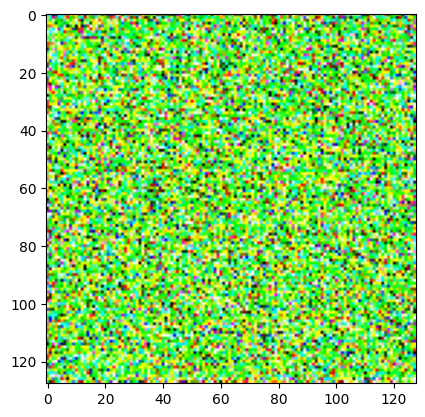

In [14]:
image = to_pil( sampled_images[0,:,:,:].cpu()  )

plt.imshow (image)
plt.show()

#### Now define dataset, define training loop, etc.

In [17]:
im_res

128

In [18]:
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from datasets import load_dataset, DatasetDict
import os

# Custom dataset class for image pairs
class ImageDataset_ImagePairs(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        # Get the image from the dataset
        image = self.dataset[index]['image']
        image = image.convert('RGB')
        # Apply the transform to the image
        image = self.transform(image)
        return image

# Function to load and split the dataset
def ImagePairs_load_split_train_test(dataset_name, valid_size=0.2, im_res=256, batch_size_=16):
    train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize((im_res, im_res)),
        transforms.ToTensor(),
    ])
    
    test_transforms = transforms.Compose([
        transforms.Resize((im_res, im_res)),
        transforms.ToTensor(),
    ])

    # Load the dataset from Hugging Face
    dataset = load_dataset(dataset_name)
    
    # Split the dataset into training and testing sets
    dataset = dataset['train'].train_test_split(test_size=valid_size, seed=1)
    
    # Create custom datasets
    train_data = ImageDataset_ImagePairs(dataset['train'], train_transforms)
    test_data = ImageDataset_ImagePairs(dataset['test'], test_transforms)
    
    # Create DataLoaders
    trainloader = DataLoader(train_data, batch_size=batch_size_, shuffle=True)
    testloader = DataLoader(test_data, batch_size=batch_size_, shuffle=False)
    
    return trainloader, testloader

# Parameters
dataset_name = 'lamm-mit/leaf-images-augmented'
 
batch_size_ = 16

# Load the data
trainloader, testloader = ImagePairs_load_split_train_test(dataset_name, valid_size=0.01, im_res=im_res, batch_size_=batch_size_)

# Print dataset information
print("Number of training batches: ", len(trainloader), "batch size= ", batch_size_, "total: ", len(trainloader) * batch_size_)
print("Number of test batches: ", len(testloader), "batch size= ", batch_size_, "total: ", len(testloader) * batch_size_)
print("TOTAL images (account for full batches): ", len(trainloader) * batch_size_ + len(testloader) * batch_size_)

Number of training batches:  69 batch size=  16 total:  1104
Number of test batches:  1 batch size=  16 total:  16
TOTAL images (account for full batches):  1120


#### Define optimizer (Note: Loss calculated directly in model)

In [19]:
optimizer = optim.Adam(model.parameters(), lr=1e-5, betas =(0.99, 0.999))

In [20]:
large_number=9999999

def train_epochs (diffusion, data_loader, epochs=10000, 
                 startep=0,
                 train_losses=[],  
                 save_every_iteration=False, 
                 num_examples=4):
     
    smallest_loss=large_number
    for i in range(startep, epochs+startep):
        steps=0
        loss_total=0
        torch.cuda.empty_cache()
        start = time.time()
        for  training_images in tqdm(data_loader):
            loss = diffusion(training_images.to(device))
 
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            loss_total=loss_total+loss.cpu().detach().numpy()
        
            steps=steps+1
        
        epoch_train_loss=loss_total/len (data_loader)
        train_losses.append (epoch_train_loss)
        
        print(f'\nepoch {i}: loss = {epoch_train_loss}, time taken = { (time.time()-start)/60. }')

        print (f"Producing {num_examples} samples...")
        images =  diffusion.sample(batch_size = num_examples)
        figure, axis = plt.subplots(1, num_examples, figsize=(num_examples*4, 4))
        
        for iex in range (num_examples): #plot multiple examples...

            image = to_pil( images[iex,:,:,:].cpu()  )

            axis[iex].imshow(image)
            axis[iex].set_title (f'Sample {iex}')

        figure.savefig(f'{prefix}/comp_sample-epoch-{i}_sample-{iex}.png')

        plt.show()

        plt.plot(train_losses, label='Training loss')
        plt.legend(loc="upper right")

        outname =  f"{prefix}/losshistory_epoch-{i}.jpg"
        plt.savefig(outname, dpi=300)
        plt.show()

        if i>=startep:
            if save_every_iteration:
                
                print (f"Saving checkpoint: ", f'diffusion_model_{i:05}.pickle')
                
                with open(f'diffusion_model_{i:05}.pickle', 'wb') as handle:
                    pickle.dump(diffusion, handle, protocol=pickle.HIGHEST_PROTOCOL)
            if save_every_iteration==False:
                if epoch_train_loss<smallest_loss:
                    smallest_loss=epoch_train_loss
                    
                    print (f"Smaller loss found, saving checkpoint: ", f'diffusion_model_{i:05}.pickle')
                    with open(f'diffusion_model_{i:05}.pickle', 'wb') as handle:
                        pickle.dump(diffusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return train_losses

In [21]:
def sample_images (diffusion, num_examplesi, num_examplesj, tag=9999):
    iex=0
    
    print (f"Producing {num_examplesi*num_examplesj} samples...")
    images =  diffusion.sample(batch_size = num_examplesi*num_examplesj)
    figure, axis = plt.subplots(num_examplesi, num_examplesj, figsize=(num_examplesi*3, num_examplesj*3))
    for iiex in range (num_examplesi): #plot multiple examples...
        for jjex in range (num_examplesj): #plot multiple examples...

            image = to_pil( images[iex,:,:,:].cpu()  )

            axis[jjex,iiex].imshow(image)
            axis[jjex,iiex].set_title (f'Sample {iex}')
            axis[jjex,iiex].axis('off')
            
            iex=iex+1
            
    figure.savefig(f'{prefix}/multiple_sample-epoch_sample_{tag:05}.png')

    plt.show()

In [ ]:
train_losses=[]
train_losses= train_epochs (diffusion,  
                    trainloader, epochs=500,
                    startep=0, 
                    train_losses=train_losses,  )


Producing 36 samples...


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

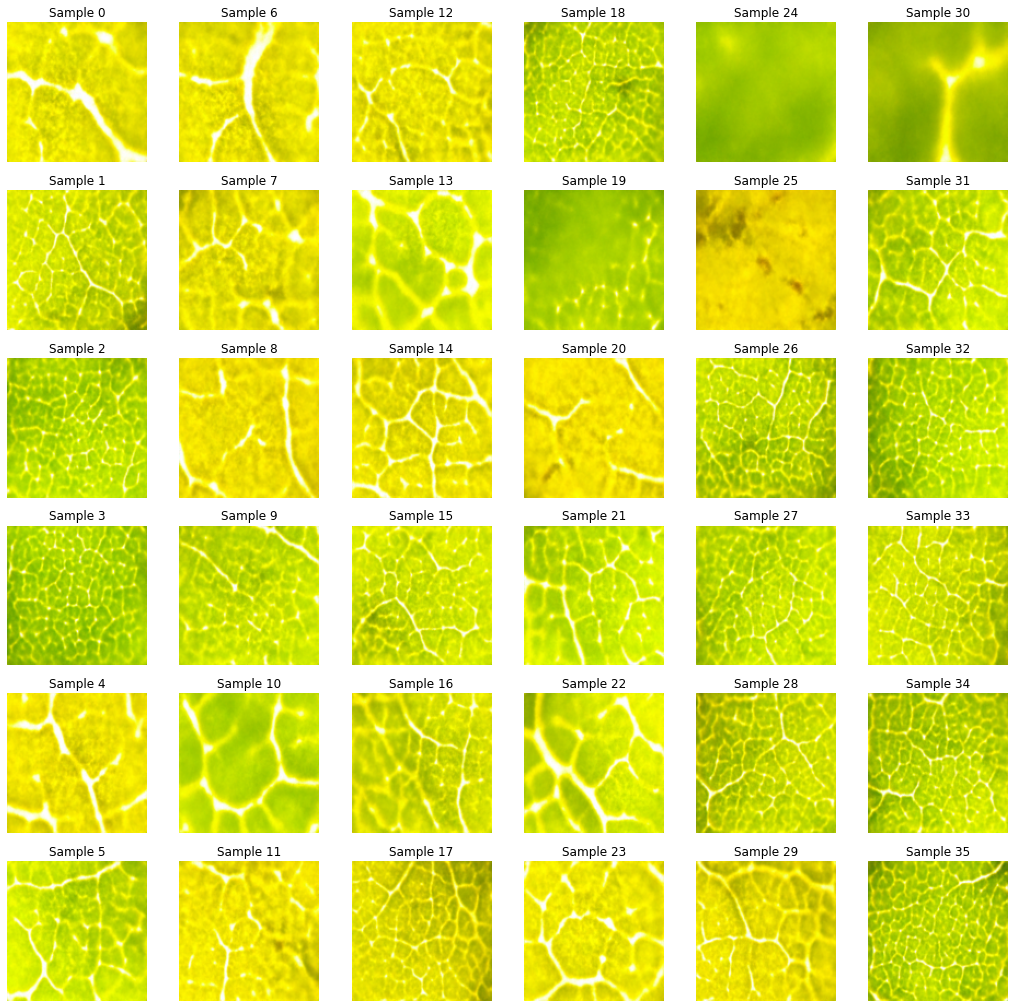

In [33]:
sample_images (diffusion, 6, 6, tag=0)

Producing 36 samples...


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

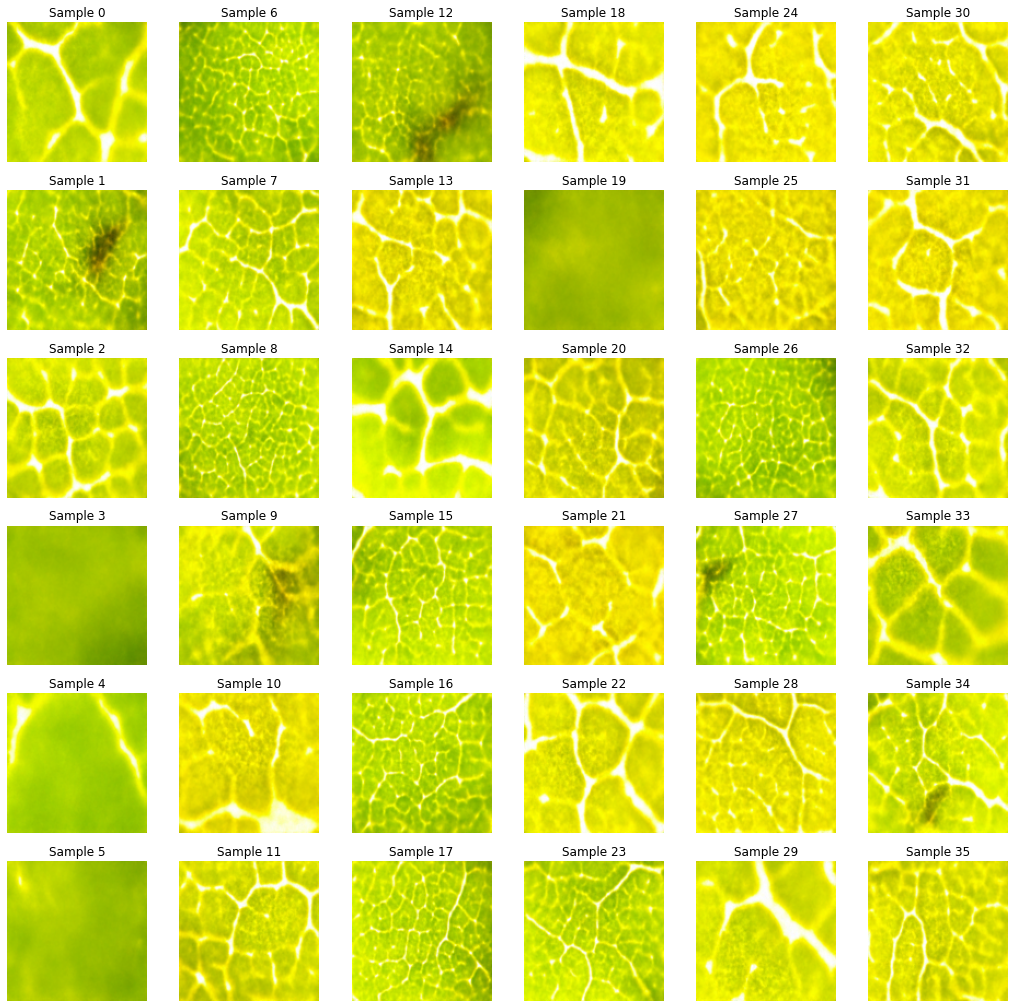

In [34]:
sample_images (diffusion, 6, 6, tag=1)

### Save and load model checkpoint

In [32]:
# loading library
import pickle
  
# saving
with open('diffusion_model.pickle', 'wb') as handle:
    pickle.dump(diffusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# loading
with open('diffusion_model.pickle', 'rb') as handle:
    diffusion = pickle.load(handle)

### Continue training after loading

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-6, betas =(0.99, 0.999))
train_losses= train_epochs (diffusion,  
                    trainloader, epochs=10,
                    startep=400, 
                    train_losses=train_losses,save_every_iteration=True )

Producing 36 samples...


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

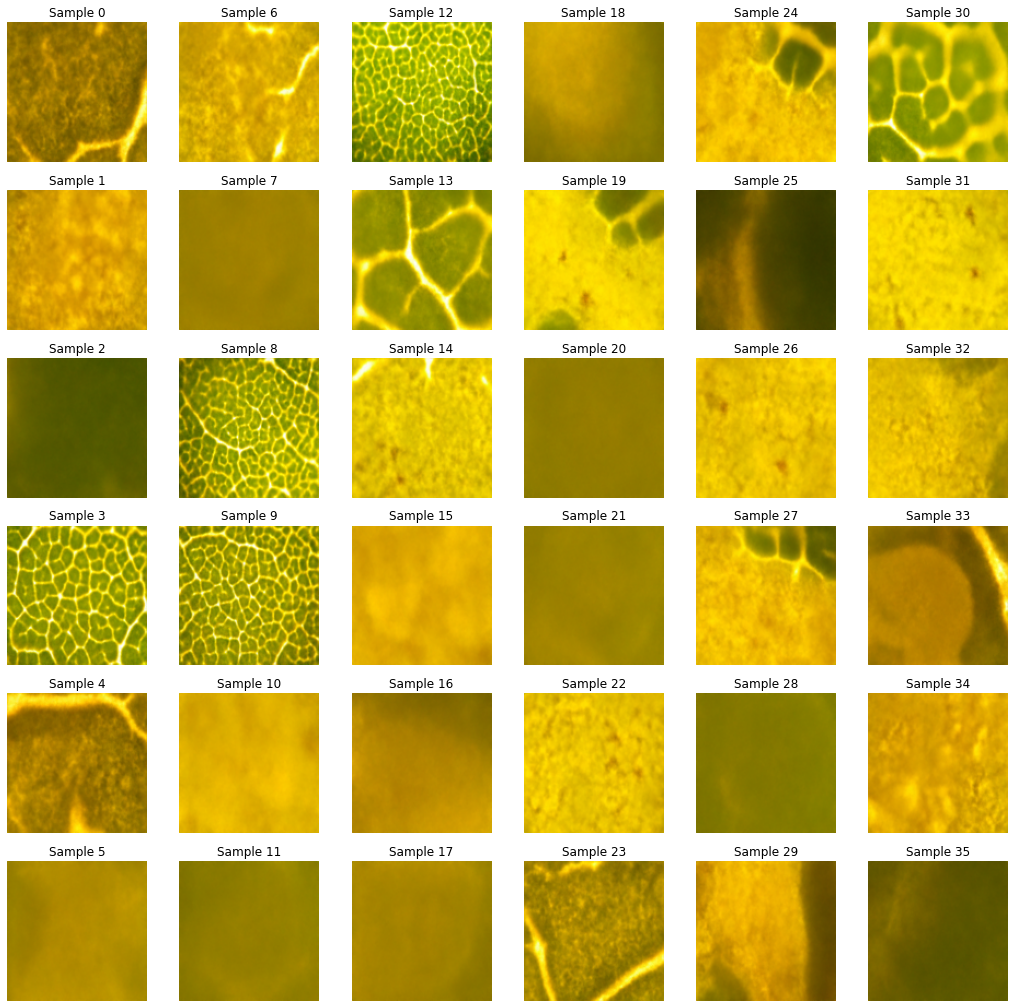

In [37]:
sample_images (diffusion, 6, 6, tag=3)

### Loading different checkpoint

In [38]:
with open('diffusion_model_00400.pickle', 'rb') as handle:
    diffusion = pickle.load(handle)

Producing 36 samples...


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

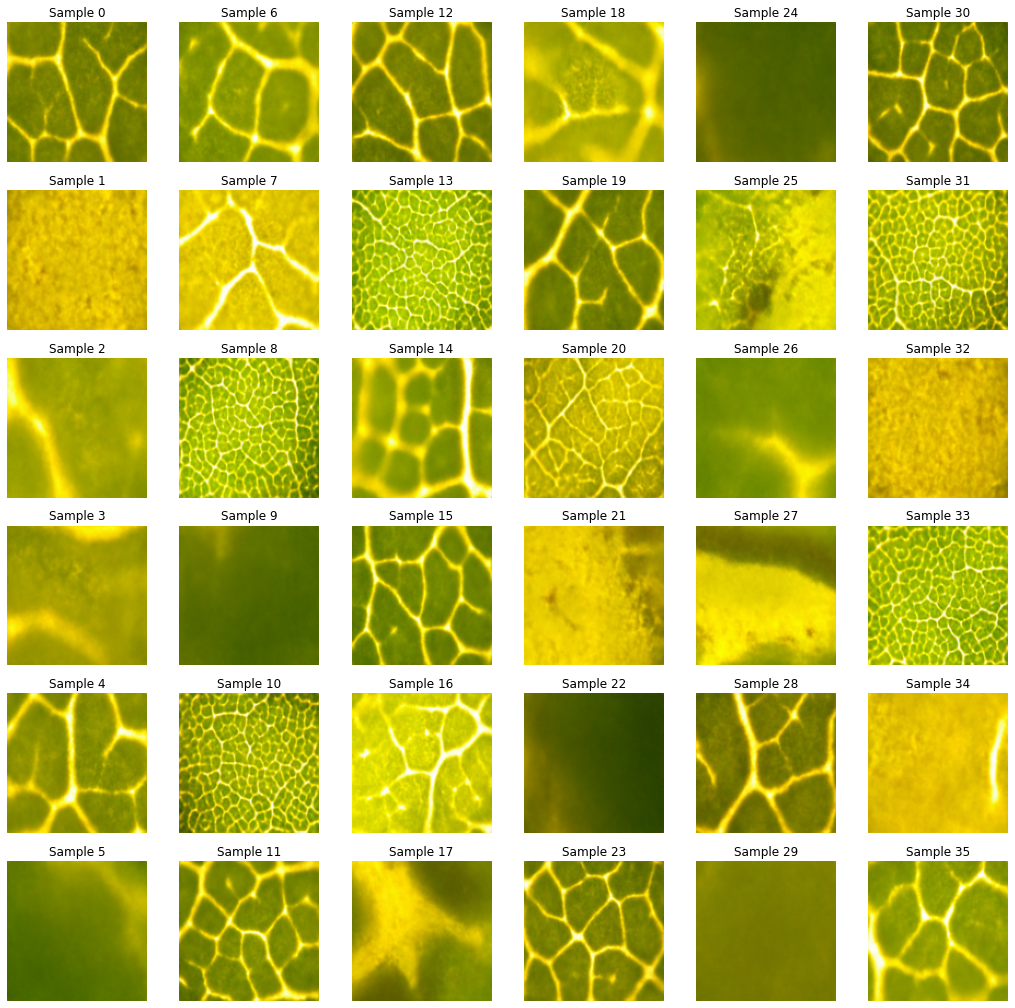

In [39]:
sample_images (diffusion, 6, 6, tag=400)